# Part 1: Prliminary analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
df = pd.read_csv("training.csv")#.set_index("article_number")
df.head()
#df.info()


,article_number,article_words,topic
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT


In [3]:
data = df[df.topic != "IRRELEVANT"].reset_index(drop=True)

## Some graphs about the number of words in each class

In [4]:
data['word_count'] = data.article_words.str.count(",")+1

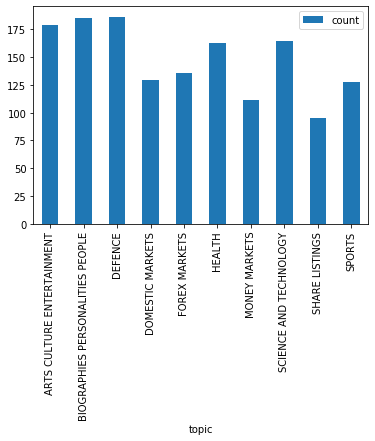

In [5]:
word_count_distribution = data.groupby("topic").word_count.mean().plot(kind="bar", label="count", legend="best")

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Text xticklabel objects>)

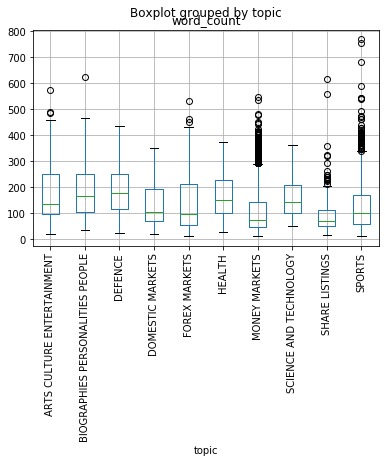

In [6]:
data.boxplot(column ='word_count',by ='topic')
plt.xticks(rotation=90)

## Counting the most frequent five words in each class

In [7]:
topic_group = data.groupby('topic')
most_frequent_word_list = {}
for name, group in topic_group :
    frequent_words = Counter(" ".join(group["article_words"]).split(",")).most_common(5)
    most_frequent_word_list.update({name:frequent_words})


In [8]:
most_frequent_word_list


{'ARTS CULTURE ENTERTAINMENT': [('year', 156),
  ('film', 153),
  ('million', 102),
  ('stat', 83),
  ('work', 81)],
 'BIOGRAPHIES PERSONALITIES PEOPLE': [('year', 249),
  ('presid', 198),
  ('yeltsin', 140),
  ('stat', 133),
  ('hospit', 124)],
 'DEFENCE': [('nato', 511),
  ('stat', 410),
  ('milit', 406),
  ('forc', 381),
  ('defend', 357)],
 'DOMESTIC MARKETS': [('import', 541),
  ('ton', 324),
  ('percent', 265),
  ('year', 262),
  ('oil', 191)],
 'FOREX MARKETS': [('dollar', 3358),
  ('bank', 2178),
  ('rate', 1720),
  ('trad', 1671),
  ('market', 1662)],
 'HEALTH': [('year', 253),
  ('health', 245),
  ('stat', 241),
  ('diseas', 184),
  ('tobacc', 169)],
 'MONEY MARKETS': [('bank', 4447),
  ('rate', 3684),
  ('percent', 3515),
  ('dollar', 3387),
  ('market', 2890)],
 'SCIENCE AND TECHNOLOGY': [('spac', 141),
  ('mir', 110),
  ('shuttl', 83),
  ('scient', 77),
  ('year', 73)],
 'SHARE LISTINGS': [('shar', 740),
  ('compan', 391),
  ('list', 347),
  ('million', 295),
  ('stock', 2

## Yangqi's work Agenda 

### Feature engineering

1. Pure word count method (Yunze)

2. Pure TF-IDF method (Raymond) 

3. Word count method with threshold (min max) *convert to TF-IDF*

4. Key words word count (top 10 in each group) give you 100 words *convert to TF-IDF*

### SVM 

1. build easy svm model 
    1. Train the model 
    2. Develop the model 
    3. Accuracy measure 
    4. Fit the test set
    5. Accuracy measure and recommendation 

2. SVM with grid search


3. SVM to classify irrelevant and relevant 


### Recommendation step

## Part 2 Construct different features datasets

In [1]:
import warnings

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [2]:
df = pd.read_csv("training.csv")
train_x_ori = df.article_words

In [3]:
vect = CountVectorizer().fit(train_x_ori)
print(f"vocabulary size: {len(vect.vocabulary_)}")
features = vect.get_feature_names()
#print(f"The top 20 most frequent words:\n{features[:20]}")
#print("\nFeatures 20010 to 20030:\n{}".format(features[20010:20030]))
#print("\nEvery 2000th feature:\n{}".format(features[::2000]))

vocabulary size: 35822


**2.1 count vector features w/ min max df**

In [4]:
train_x_wc = vect.transform(train_x_ori)
print(train_x_wc.shape) #first features dataset

(9500, 35822)


In [5]:
vect_min = CountVectorizer(min_df=5).fit(train_x_ori)
train_x_wc_min = vect_min.transform(train_x_ori)
print(train_x_wc_min.shape) #second features dataset, with minimum word frequent as 5 


(9500, 9495)


In [6]:
sum_words = train_x_wc_min.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vect_min.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print(f"The top 20 most frequent words:\n{words_freq[:20]}")
print(f"The top 20 most infrequent words:\n{words_freq[-20:]}")

The top 20 most frequent words:
[('percent', 11610), ('bank', 9937), ('year', 9241), ('market', 8571), ('trad', 8446), ('rate', 7931), ('dollar', 7576), ('million', 7034), ('stat', 5162), ('cent', 4987), ('deal', 4795), ('shar', 4712), ('month', 4580), ('day', 4526), ('week', 4372), ('high', 4299), ('compan', 4041), ('pric', 3888), ('expect', 3877), ('clos', 3860)]
The top 20 most infrequent words:
[('livel', 5), ('renown', 5), ('indemn', 5), ('underneath', 5), ('cousin', 5), ('eek', 5), ('potat', 5), ('downs', 5), ('velli', 5), ('ilan', 5), ('and', 5), ('catherwood', 5), ('sandon', 5), ('dagmar', 5), ('retribut', 5), ('windy', 5), ('brow', 5), ('babel', 5), ('manager', 5), ('ventil', 5)]


In [105]:
#train_x_wc_max = CountVectorizer(max_df=500).fit(train_x_ori).transform(train_x_ori)
#print(train_x_wc_max.shape)

**2.2 tf-idf features w/ min max df**

In [7]:
train_x_tf = TfidfVectorizer().fit_transform(train_x_ori)
print(train_x_tf.shape)

(9500, 35822)


In [8]:
train_x_tf_min = TfidfVectorizer(min_df=5).fit_transform(train_x_ori)
print(train_x_tf_min.shape)

(9500, 9495)


In [9]:
#train_x_tf_max = TfidfVectorizer(max_df=500).fit_transform(train_x_ori)
#print(train_x_tf_max.shape)

**2.3 Key words methods**

In [5]:
def word_count_function(word_list,topic_df):
    #return the only the words in word_list occur in the topic_df
    occurence_df = pd.DataFrame() #show their occurence in other topics 
    for words in word_list:
        occurence_dict = {}
        for name, group in topic_df :
            word_counter = Counter(" ".join(group["article_words"]).split(","))
            occurence = word_counter[words]
            avg_occurence = occurence / len(group)
            occurence_dict.update({name:avg_occurence})
        occur_series = pd.Series(occurence_dict) 
        occur_series.name = words
        occurence_df = occurence_df.append(occur_series, ignore_index = True)
    return(occurence_df.T)

In [6]:
#finding the most frequent words in training set by topics
topic_group = df.groupby('topic')
most_frequent_word_list = {}
word_list_10 = []
for name, group in topic_group :
    frequent_words = Counter(" ".join(group["article_words"]).split(",")).most_common(10)
    most_frequent_word_list.update({name:frequent_words})
    common_words = [i[0] for i in frequent_words]
    word_list_10 = word_list_10 + common_words

In [12]:
print(most_frequent_word_list)


{'ARTS CULTURE ENTERTAINMENT': [('year', 156), ('film', 153), ('million', 102), ('stat', 83), ('work', 81), ('offic', 80), ('show', 72), ('releas', 72), ('peopl', 70), ('music', 69)], 'BIOGRAPHIES PERSONALITIES PEOPLE': [('year', 249), ('presid', 198), ('yeltsin', 140), ('stat', 133), ('hospit', 124), ('offic', 122), ('lead', 121), ('minist', 119), ('told', 117), ('report', 113)], 'DEFENCE': [('nato', 511), ('stat', 410), ('milit', 406), ('forc', 381), ('defend', 357), ('minist', 345), ('offic', 317), ('russia', 299), ('presid', 238), ('plan', 235)], 'DOMESTIC MARKETS': [('import', 541), ('ton', 324), ('percent', 265), ('year', 262), ('oil', 191), ('trad', 189), ('chin', 186), ('export', 161), ('million', 151), ('produc', 140)], 'FOREX MARKETS': [('dollar', 3358), ('bank', 2178), ('rate', 1720), ('trad', 1671), ('market', 1662), ('percent', 1336), ('currenc', 1214), ('deal', 1208), ('mark', 1191), ('yen', 962)], 'HEALTH': [('year', 253), ('health', 245), ('stat', 241), ('diseas', 184),

In [13]:
print(word_list_10)

['year', 'film', 'million', 'stat', 'work', 'offic', 'show', 'releas', 'peopl', 'music', 'year', 'presid', 'yeltsin', 'stat', 'hospit', 'offic', 'lead', 'minist', 'told', 'report', 'nato', 'stat', 'milit', 'forc', 'defend', 'minist', 'offic', 'russia', 'presid', 'plan', 'import', 'ton', 'percent', 'year', 'oil', 'trad', 'chin', 'export', 'million', 'produc', 'dollar', 'bank', 'rate', 'trad', 'market', 'percent', 'currenc', 'deal', 'mark', 'yen', 'year', 'health', 'stat', 'diseas', 'tobacc', 'drug', 'peopl', 'canc', 'study', 'percent', 'percent', 'year', 'million', 'trad', 'market', 'shar', 'compan', 'stat', 'bank', 'pric', 'bank', 'rate', 'percent', 'dollar', 'market', 'trad', 'day', 'deal', 'mark', 'currenc', 'spac', 'mir', 'shuttl', 'scient', 'year', 'station', 'crew', 'mission', 'system', 'nasa', 'shar', 'compan', 'list', 'million', 'stock', 'trad', 'exchang', 'pric', 'percent', 'market', 'play', 'win', 'game', 'year', 'match', 'champ', 'world', 'cup', 'team', 'scor']


In [14]:
word_list_group = [ [i for i in word_list_10[j*10 :(j+1)*10 ] if word_list_10.count(i) == 1] for j in range(11) ]
print(word_list_group)

[['film', 'work', 'show', 'releas', 'music'], ['yeltsin', 'hospit', 'lead', 'told', 'report'], ['nato', 'milit', 'forc', 'defend', 'russia', 'plan'], ['import', 'ton', 'oil', 'chin', 'export', 'produc'], ['yen'], ['health', 'diseas', 'tobacc', 'drug', 'canc', 'study'], [], ['day'], ['spac', 'mir', 'shuttl', 'scient', 'station', 'crew', 'mission', 'system', 'nasa'], ['list', 'stock', 'exchang'], ['play', 'win', 'game', 'match', 'champ', 'world', 'cup', 'team', 'scor']]


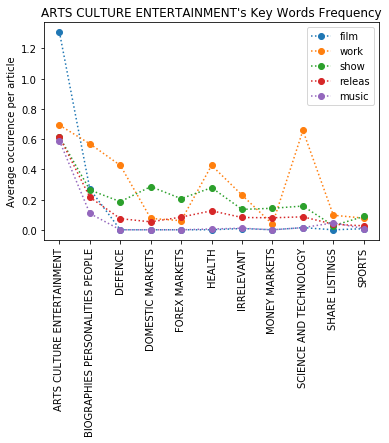

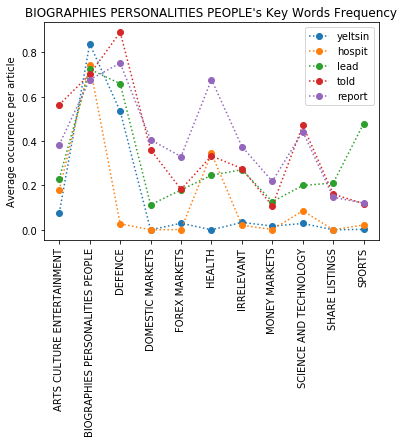

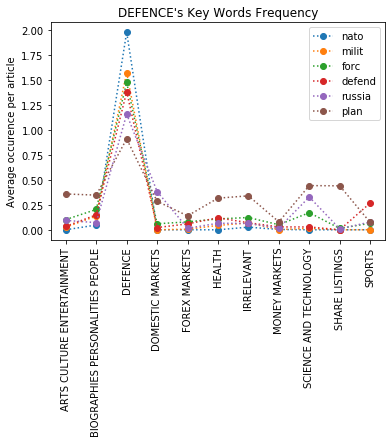

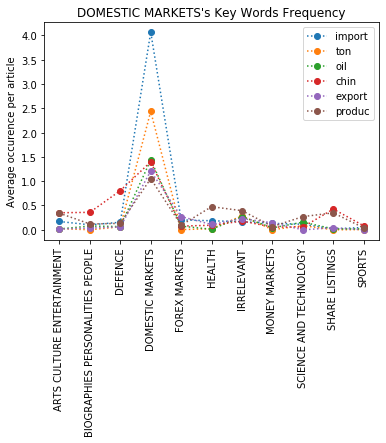

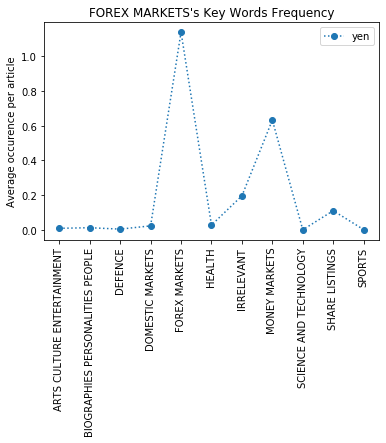

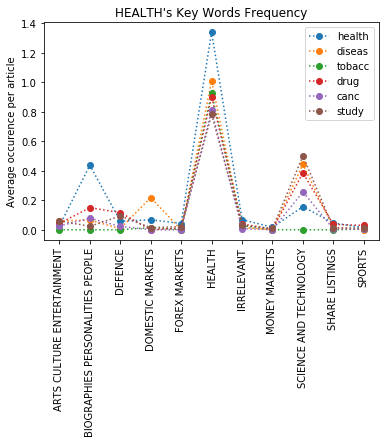

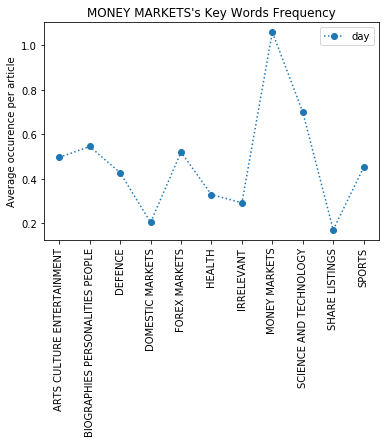

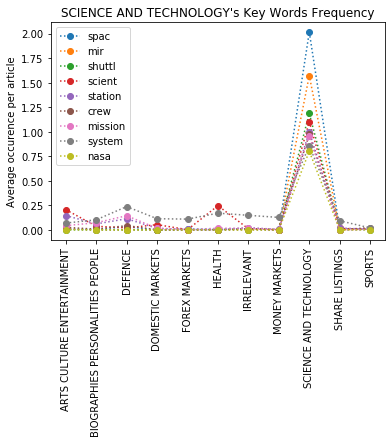

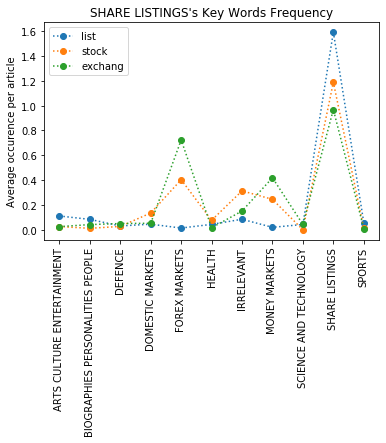

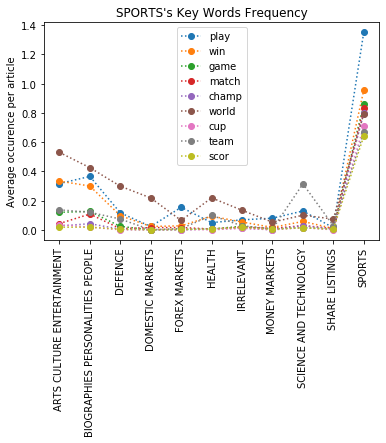

In [23]:
#visaulize key word's performance
for i in range(11):
    if i == 6:
        continue #irrelevant do not have any words
    my_words = word_list_group[i]
    my_df = word_count_function(my_words,topic_group)
    
    my_df.columns = my_words
    my_df.plot(marker='o',style = ':')
    plt.xticks(np.arange(11), list(my_df.index),rotation=90)

    plt.title(list(my_df.index)[i] + '\'s Key Words Frequency')
    plt.ylabel('Average occurence per article')
    plt.show()

**2.4: construct a cleaning dataset by the keywords**

In [7]:
#unique_words  = [item for sublist in word_list_group for item in sublist]
def keep_key_words(x,word_list = word_list_10):
    key_list = [i for i in x.split(",") if i in  word_list]
    key_str = str(key_list).replace("'","").replace(" ","").replace("[","").replace("]","")
    return(key_str)
#def keep_key_words2(x,word_list = unique_words):
    #key_list = [i for i in x.split(",") if i in  word_list]
    #key_str = str(key_list).replace("'","").replace(" ","").replace("[","").replace("]","")
    #return(key_str)

In [8]:
train_x_kw1 = train_x_ori.apply(keep_key_words)
#train_x_kw2 = train_x_ori.apply(keep_key_words2)

# Part 2 conclusions: The following datasets are available for model fitting 
1. train_x_wc; train_x_wc_min; train_x_wc_max (min max for number of articles for occurence)
2. train_x_tf; train_x_tf_min; train_x_tf_max
3. train_x_kw1; train_x_kw2 (you need to transfer it to wc and tf-idf as well)

# Part 3 SVM model 

1. Preliminary results using different datasets 
2. grid search for hyperparameters (cv)
3. test set results

**3.1 preliminary results**

In [9]:
from sklearn import svm
from sklearn.model_selection import cross_val_score,GridSearchCV

In [22]:
y_train = df.topic
train_x_kw1_tf = TfidfVectorizer().fit_transform(train_x_kw1)
train_x_kw1_wc = CountVectorizer().fit_transform(train_x_kw1)
train_x_kw2_tf = TfidfVectorizer().fit_transform(train_x_kw2)
train_x_kw2_wc = CountVectorizer().fit_transform(train_x_kw2)

x_train_list = [train_x_wc,train_x_wc_min,train_x_tf, train_x_tf_min,train_x_kw1_tf ,train_x_kw1_wc, train_x_kw2_tf, train_x_kw2_wc ]
x_train_name = ['train_x_wc','train_x_wc_min','train_x_tf', 'train_x_tf_min','train_x_kw1_tf' ,'train_x_kw1_wc', 'train_x_kw2_tf', 'train_x_kw2_wc' ]
# all the potential training set 

In [47]:
accuracy_list = []
for i in range(len(x_train_list)):
    accs = cross_val_score(svm.SVC(gamma=0.001, C=100.), x_train_list[i], df.topic, cv=5)
    print(x_train_name[i])
    print(f"Mean accuracy of (std): {np.mean(accs): .3f} ({np.std(accs): .3f})")
    accuracy_list.append(np.mean(accs))

train_x_wc
Mean accuracy of (std):  0.756 ( 0.007)
train_x_wc_min
Mean accuracy of (std):  0.754 ( 0.005)
train_x_tf
Mean accuracy of (std):  0.739 ( 0.003)
train_x_tf_min
Mean accuracy of (std):  0.743 ( 0.003)
train_x_kw1_tf
Mean accuracy of (std):  0.719 ( 0.004)
train_x_kw1_wc
Mean accuracy of (std):  0.732 ( 0.009)
train_x_kw2_tf
Mean accuracy of (std):  0.643 ( 0.008)
train_x_kw2_wc
Mean accuracy of (std):  0.646 ( 0.005)


In [30]:
#performance of classifying irrelevant
df['IR_binary'] = df['topic'] == 'IRRELEVANT'
accuracy_irrelevant = []
y_train_ir = df.IR_binary
for i in range(len(x_train_list)):
    accs = cross_val_score(svm.SVC(gamma=0.001, C=100.), x_train_list[i], y_train_ir, cv=5)
    print(x_train_name[i])
    print(f"Mean accuracy of (std): {np.mean(accs): .3f} ({np.std(accs): .3f})")
    accuracy_irrelevant.append(np.mean(accs))

train_x_wc
Mean accuracy of (std):  0.839 ( 0.003)
train_x_wc_min
Mean accuracy of (std):  0.839 ( 0.006)
train_x_tf
Mean accuracy of (std):  0.858 ( 0.005)
train_x_tf_min
Mean accuracy of (std):  0.862 ( 0.005)
train_x_kw1_tf
Mean accuracy of (std):  0.800 ( 0.003)
train_x_kw1_wc
Mean accuracy of (std):  0.809 ( 0.004)
train_x_kw2_tf
Mean accuracy of (std):  0.715 ( 0.009)
train_x_kw2_wc
Mean accuracy of (std):  0.720 ( 0.006)


In [65]:
#remove irrelevant group 
y_train_nir = df['topic'][df.IR_binary == 0 ]
accuracy_relevant = []
for i in range(len(x_train_list)):
    accs = cross_val_score(svm.SVC(gamma=0.001, C=100.), x_train_list[i][y_train_nir.index], y_train_nir, cv=5)
    print(x_train_name[i])
    print(f"Mean accuracy of (std): {np.mean(accs): .3f} ({np.std(accs): .3f})")
    accuracy_irrelevant.append(np.mean(accs))

train_x_wc
Mean accuracy of (std):  0.756 ( 0.005)
train_x_wc_min
Mean accuracy of (std):  0.756 ( 0.006)
train_x_tf
Mean accuracy of (std):  0.718 ( 0.004)
train_x_tf_min
Mean accuracy of (std):  0.735 ( 0.004)
train_x_kw1_tf
Mean accuracy of (std):  0.745 ( 0.005)
train_x_kw1_wc
Mean accuracy of (std):  0.738 ( 0.007)
train_x_kw2_tf
Mean accuracy of (std):  0.683 ( 0.010)
train_x_kw2_wc
Mean accuracy of (std):  0.689 ( 0.007)


**3.2 grid search for model tuning**

In [23]:
#grid search
param_grid = {'C': np.geomspace(0.01,100,num=5,endpoint=True), 'gamma' : np.geomspace(0.1,10,num=3,endpoint=True),
              'class_weight': [None,'balanced'], 'decision_function_shape': ['ovo','ovr']}
param_grid_weight = {'class_weight': [None,'balanced']}
param_grid_decision_shape = { 'decision_function_shape': ['ovo','ovr']}
param_grid_gamma = {'gamma' : np.geomspace(0.01,100,num=3,endpoint=True)}
param_grid_c = {'C': np.geomspace(0.01,100,num=5,endpoint=True)}

In [21]:
%%time
grid = GridSearchCV(svm.SVC(), param_grid=param_grid_weight, cv=5, n_jobs=-1)
grid.fit(train_x_wc_min, y_train)

Wall time: 5min 32s


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [22]:
print(f"Best parameter: {grid.best_params_}")

Best parameter: {'class_weight': 'balanced'}


In [25]:
%%time
grid = GridSearchCV(svm.SVC(class_weight = 'balanced'), param_grid=param_grid_decision_shape, cv=5, n_jobs=-1)
grid.fit(train_x_wc_min, y_train)
print(f"Best parameter: {grid.best_params_}")

Best parameter: {'decision_function_shape': 'ovo'}
Wall time: 5min 48s


In [27]:
%%time
grid = GridSearchCV(svm.SVC(class_weight = 'balanced',decision_function_shape = 'ovo' ), param_grid=param_grid_gamma, cv=5, n_jobs=-1)
grid.fit(train_x_wc_min, y_train)
print(f"Best parameter: {grid.best_params_}")

Best parameter: {'gamma': 0.01}
Wall time: 14min 58s


In [ ]:
# best paramater indicates a relative simple model 

In [29]:
%%time
grid = GridSearchCV(svm.SVC(class_weight = 'balanced',decision_function_shape = 'ovo', gamma = 0.01 ), param_grid=param_grid_c, cv=5, n_jobs=-1)
grid.fit(train_x_wc_min, y_train)
print(f"Best parameter: {grid.best_params_}")

Best parameter: {'C': 10.0}
Wall time: 21min 19s


In [24]:
#check if the results is consistent using a smaller samle 
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(train_x_kw1_wc, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'class_weight': [None, 'balanced'],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': array([ 0.1,  1. , 10. ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
print(f"Best parameter: {grid.best_params_}")

Best parameter: {'C': 1.0, 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': 0.1}


In [26]:
%%time
grid = GridSearchCV(svm.SVC(decision_function_shape = 'ovo', gamma = 0.01), param_grid=param_grid_weight, cv=5, n_jobs=-1)
grid.fit(train_x_wc_min, y_train)
print(f"Best parameter: {grid.best_params_}")

Best parameter: {'class_weight': 'balanced'}
Wall time: 9min 32s


**3.3 test set performance**

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
test_sample = pd.read_csv("test.csv")
test_y = test_sample.topic

test_x_kw = test_sample.article_words.apply(keep_key_words) #keep key words in test set
wc_key = CountVectorizer().fit(train_x_kw1) #word count using previous key word vectorizer
test_x_kw_wc = wc_key.transform(test_x_kw)


In [89]:
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(train_x_kw1_wc,y_train )

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [95]:
#performance
y_pred = clf.predict(test_x_kw_wc)
#y_pred_pr = clf.predict_proba(test_x_kw_wc)
acc_test = clf.score(test_x_kw_wc, test_y)
print(f"Accuracy on test set: {acc_test:.3f}")

Accuracy on test set: 0.726


In [99]:
# Compute confusion matrix on test set
conf_matrix = confusion_matrix(test_y, y_pred)
print(conf_matrix)

[[  1   0   0   0   0   0   2   0   0   0   0]
 [  2   0   0   0   0   1  11   0   0   0   1]
 [  0   0   7   0   0   0   5   0   1   0   0]
 [  0   0   0   1   0   0   1   0   0   0   0]
 [  0   0   0   0   8   0   3  37   0   0   0]
 [  0   0   0   0   0   6   7   0   1   0   0]
 [  0   0   1   1   1   1 237  19   0   2   4]
 [  0   0   0   0   7   0  18  44   0   0   0]
 [  0   0   0   0   0   1   2   0   0   0   0]
 [  0   0   0   0   0   0   5   0   0   2   0]
 [  0   0   0   0   0   0   3   0   0   0  57]]


AttributeError: 'SVC' object has no attribute 'named_steps'

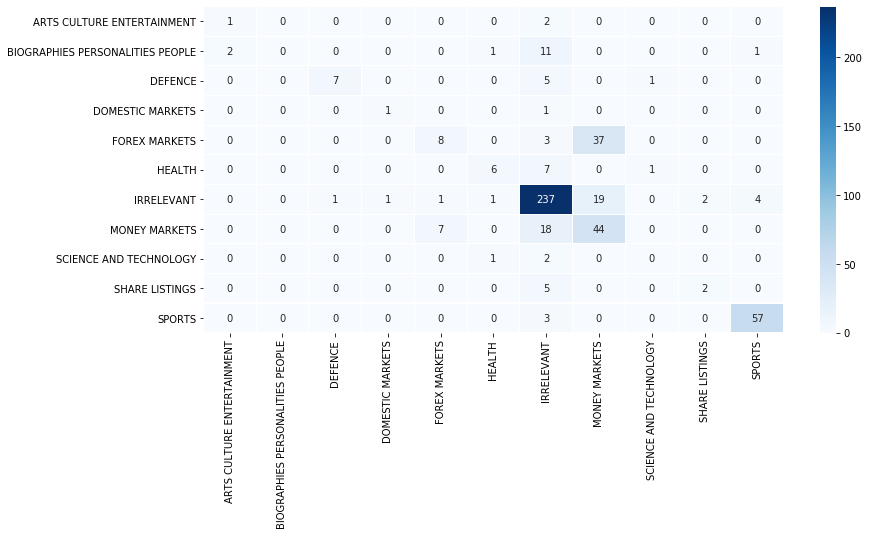

In [103]:
fig1 = plt.figure(figsize=(13,6))
sns.heatmap(conf_matrix,
#             square=True,
            annot=True, # show numbers in each cell
            fmt='d', # set number format to integer in each cell
            yticklabels=clf.classes_,
            xticklabels=clf.classes_,
            cmap="Blues",
#             linecolor="k",
            linewidths=.1,
           )
plt.title(
          f"Confusion Matrix on Test Set | " 
          f"Classifier: {'+'.join([step for step in clf.named_steps.keys()])}", 
          fontsize=14)
plt.xlabel("Actual: False positives for y != x", fontsize=12)
plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
plt.show()

# Key word dataset 

In [114]:
df['key_word_10'] = train_x_kw1

0    stock,rate,defend,bank,bank,bank,bank,bank,dol...
1    day,day,day,bank,year,dollar,dollar,deal,deal,...
2    world,world,stat,stat,stat,stat,year,releas,re...
3    play,bank,bank,mark,mark,percent,percent,perce...
4                                                  day
Name: article_words, dtype: object

In [120]:
def word_list_generator(data_group, n=10):
    my_word_list= []
    for name, group in data_group :
        frequent_words = Counter(" ".join(group["article_words"]).split(",")).most_common(n)
        #most_frequent_word_list.update({name:frequent_words})
        common_words = [i[0] for i in frequent_words]
        my_word_list = my_word_list + common_words
    return(my_word_list)

In [122]:
word_list20 = word_list_generator(topic_group, n=20)
train_x_20 = train_x_ori.apply(keep_key_words, args=(word_list20,))
df['key_word_20'] = train_x_20

In [130]:
word_list50 = word_list_generator(topic_group, n=50)
train_x_50 = train_x_ori.apply(keep_key_words, args=(word_list50,))
df['key_word_50'] = train_x_50

In [132]:
word_list100 = word_list_generator(topic_group, n=100)
train_x_100 = train_x_ori.apply(keep_key_words, args=(word_list100,))
df['key_word_100'] = train_x_100

In [134]:
df.to_csv('keyword.csv')

In [135]:
df.head()

,article_number,article_words,topic,IR_binary,key_word_10,key_word_20,key_word_50,key_word_100
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS,False,"stock,rate,defend,bank,bank,bank,bank,bank,dol...","cent,cent,cent,stock,rate,end,won,won,won,won,...","open,cent,cent,cent,stock,rate,end,won,won,won...","open,cent,cent,cent,stock,rate,end,won,won,won..."
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS,False,"day,day,day,bank,year,dollar,dollar,deal,deal,...","end,end,day,day,day,point,time,bank,year,dolla...","end,end,day,day,day,point,time,bank,early,year...","end,end,day,day,day,index,point,time,busi,bank..."
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS,False,"world,world,stat,stat,stat,stat,year,releas,re...","world,world,stat,stat,stat,stat,govern,time,ye...","socc,socc,world,world,stat,stat,stat,stat,gove...","socc,socc,world,world,recent,law,stat,stat,sta..."
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS,False,"play,bank,bank,mark,mark,percent,percent,perce...","cent,cent,end,play,unit,bank,bank,mark,mark,pe...","open,cent,cent,end,play,unit,made,bank,bank,tu...","open,cent,cent,end,play,unit,made,bank,bank,ra..."
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT,True,day,"day,time,season,clos","minut,minut,minut,day,friday,friday,race,time,...","minut,minut,minut,day,friday,friday,race,time,..."


In [136]:
#convert test set as well

test_sample['key_word_10'] = test_x_kw

In [138]:
test_x_20 = test_sample.article_words.apply(keep_key_words, args=(word_list20,))
test_sample['key_word_20'] = test_x_20

test_x_50 = test_sample.article_words.apply(keep_key_words, args=(word_list50,))
test_sample['key_word_50'] = test_x_50

test_x_100 = test_sample.article_words.apply(keep_key_words, args=(word_list100,))
test_sample['key_word_100'] = test_x_100

In [141]:
test_sample.head()

,article_number,article_words,topic,key_word_10,key_word_20,key_word_50,key_word_100
0,9501,"world,complet,pharmaceut,tianjin,tianjin,chin,...",IRRELEVANT,"world,chin,chin,chin,chin,chin,chin,million,mi...","world,chin,chin,chin,chin,chin,chin,industr,gr...","world,chin,chin,chin,chin,chin,chin,industr,gr...","world,chin,chin,chin,chin,chin,chin,city,indus..."
1,9502,"copy,sunday,weekend,ec,friday,eu,includ,limit,...",IRRELEVANT,report,"eu,includ,report","sunday,friday,eu,includ,european,report,saturday","sunday,friday,eu,includ,european,commun,servic..."
2,9503,"heavy,heavy,gabriel,morn,morn,equit,cent,cent,...",FOREX MARKETS,"stock,stock,stock,rate,rate,rate,day,day,day,p...","cent,cent,cent,stock,stock,stock,rate,rate,rat...","cent,cent,cent,stock,stock,stock,rate,rate,rat...","cent,cent,cent,recent,stock,stock,stock,rate,r..."
3,9504,"research,jess,hit,anticip,comput,comput,comput...",IRRELEVANT,"day,work,offic,year,year,year,year,percent,per...","research,industr,industr,industr,industr,group...","research,comput,comput,comput,comput,comput,co...","research,hit,comput,comput,comput,comput,compu..."
4,9505,"provid,provid,luxembourg,court,court,case,opin...",IRRELEVANT,"stat,stat,stat,stat,stat,stat,stat,bank,year,r...","case,end,unit,unit,unit,unit,stat,stat,stat,st...","court,court,case,end,unit,unit,unit,unit,stat,...","court,court,case,rule,rule,law,end,unit,unit,u..."


In [142]:
test_sample.to_csv('key_word_test.csv')

# Final model check

1. check tuning model's performance in training set, test set for min and key words models 

final decision on parameters: 'balanced'; 'ovo' c= 1/ 10; gamma = 0.1

2. build up 2-layer model; check accuracy on 2-layer model in test set


In [12]:
new_dataset = pd.read_csv('keyword.csv')
new_dataset = new_dataset.replace(np.nan, '', regex=True)

In [13]:
kw_10_wc =  CountVectorizer().fit_transform(new_dataset.key_word_10)
kw_10_tf = TfidfVectorizer().fit_transform(new_dataset.key_word_10)

kw_20_wc =  CountVectorizer().fit_transform(new_dataset.key_word_20)
kw_20_tf = TfidfVectorizer().fit_transform(new_dataset.key_word_20)

kw_50_wc =  CountVectorizer().fit_transform(new_dataset.key_word_50)
kw_50_tf = TfidfVectorizer().fit_transform(new_dataset.key_word_50)

kw_100_wc =  CountVectorizer().fit_transform(new_dataset.key_word_100)
kw_100_tf = TfidfVectorizer().fit_transform(new_dataset.key_word_100)

In [14]:
accuracy_list = []
x_train_list = [ kw_10_wc, kw_10_tf, kw_20_wc, kw_20_tf,kw_50_wc,kw_50_tf,kw_100_wc,kw_100_tf]
x_train_name = [ 'kw_10_wc', 'kw_10_tf', 
                'kw_20_wc', 'kw_20_tf','kw_50_wc','kw_50_tf','kw_100_wc','kw_100_tf']
for i in range(len(x_train_list)):
    accs = cross_val_score(svm.SVC(gamma=0.001, C=100.,class_weight = 'balanced',decision_function_shape = 'ovo'), 
                           x_train_list[i], df.topic, cv=5)
    print(x_train_name[i])
    print(f"Mean accuracy of (std): {np.mean(accs): .3f} ({np.std(accs): .3f})")
    accuracy_list.append(np.mean(accs))


kw_10_wc
Mean accuracy of (std):  0.634 ( 0.004)
kw_10_tf
Mean accuracy of (std):  0.547 ( 0.006)
kw_20_wc
Mean accuracy of (std):  0.694 ( 0.004)
kw_20_tf
Mean accuracy of (std):  0.618 ( 0.005)
kw_50_wc
Mean accuracy of (std):  0.736 ( 0.006)
kw_50_tf
Mean accuracy of (std):  0.660 ( 0.005)
kw_100_wc
Mean accuracy of (std):  0.748 ( 0.005)
kw_100_tf
Mean accuracy of (std):  0.682 ( 0.006)


In [15]:
param_grid = {'C': np.geomspace(0.01,100,num=5,endpoint=True), 'gamma' : np.geomspace(0.001,10,num=5,endpoint=True),
              'class_weight': [None,'balanced'], 'decision_function_shape': ['ovo','ovr']}
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(kw_50_wc, df.topic)


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'class_weight': [None, 'balanced'],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
new_dataset.head()

,Unnamed: 0,article_number,article_words,topic,IR_binary,key_word_10,key_word_20,key_word_50,key_word_100
0,0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS,False,"stock,rate,defend,bank,bank,bank,bank,bank,dol...","cent,cent,cent,stock,rate,end,won,won,won,won,...","open,cent,cent,cent,stock,rate,end,won,won,won...","open,cent,cent,cent,stock,rate,end,won,won,won..."
1,1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS,False,"day,day,day,bank,year,dollar,dollar,deal,deal,...","end,end,day,day,day,point,time,bank,year,dolla...","end,end,day,day,day,point,time,bank,early,year...","end,end,day,day,day,index,point,time,busi,bank..."
2,2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS,False,"world,world,stat,stat,stat,stat,year,releas,re...","world,world,stat,stat,stat,stat,govern,time,ye...","socc,socc,world,world,stat,stat,stat,stat,gove...","socc,socc,world,world,recent,law,stat,stat,sta..."
3,3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS,False,"play,bank,bank,mark,mark,percent,percent,perce...","cent,cent,end,play,unit,bank,bank,mark,mark,pe...","open,cent,cent,end,play,unit,made,bank,bank,tu...","open,cent,cent,end,play,unit,made,bank,bank,ra..."
4,4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT,True,day,"day,time,season,clos","minut,minut,minut,day,friday,friday,race,time,...","minut,minut,minut,day,friday,friday,race,time,..."


In [16]:
print(f"Best parameter: {grid.best_params_}")

Best parameter: {'C': 10.0, 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': 0.001}


# Replicate Raymond's results on SVM


In [1]:
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#import altair as alt
# need to 'pip install vega' before using renderer
#alt.renderers.enable("notebook")
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing,metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,StratifiedKFold, cross_val_score
from sklearn import svm
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA,TruncatedSVD
import scipy
import os
from joblib import dump, load
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as prfs
# test for Selecting The Best Number Of Components For TSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
#from varname import varname
%matplotlib inline
#fix random seed
np.random.seed(1)

**first group: include irrelevant, SMOTE, default grid research results**

Best parameter: {'C': 10.0, 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': 0.001}

In [2]:
TRAINING_FILE = "keyword.csv"
TEST_FILE = "key_word_test.csv"
df_train = pd.read_csv(TRAINING_FILE)
df_test = pd.read_csv(TEST_FILE)
print(df_train.isnull().sum())
df_train.head(5)
new_dataset = df_train.replace(np.nan, '', regex=True)

#replace nan to empty string

Unnamed: 0         0
article_number     0
article_words      0
topic              0
IR_binary          0
key_word_10       62
key_word_20       18
key_word_50        0
key_word_100       0
dtype: int64


1. SMOTE THE DATA AND CONVERT TO word count/ tfidf
2. train the model, fit to test set 
3. output results 


In [3]:
def get_model_full(df_train):
    # get train_x and train_y
    new_df = df_train
    new_df = new_df.dropna()
    train_x = new_df.key_word.apply(lambda x: x.replace('_', ''))
    train_y = new_df.topic
    le = preprocessing.LabelEncoder()
    le.fit(train_y)
    encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    en_train_y = le.transform(train_y)
    topics = list(set(new_df['topic']))
    # Using SMOTE 1 with tfidf  to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y_tf = smote.fit_sample(train_vectors,en_train_y)
    new_train_x_tf = vectorizer.inverse_transform(smo_x)
    new_train_x_tf = pd.Series([','.join(item) for item in new_train_x_tf])
    
    # Start grid search
    #count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),new_train_x,smo_y,topics)
    #tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),new_train_x,smo_y,topics)
    
    #replace the grid search by avg_score as model is already tuning 
    accs_tf_tf = np.mean(cross_val_score(svm.SVC(gamma=0.001, C=10.,decision_function_shape = 'ovo'), 
                           TfidfVectorizer().fit_transform(new_train_x_tf), smo_y_tf, cv=5))
    
    accs_tf_wc = np.mean(cross_val_score(svm.SVC(gamma=0.001, C=10.,decision_function_shape = 'ovo'), 
                           CountVectorizer().fit_transform(new_train_x_tf), smo_y_tf, cv=5))
    
    # Using SMOTE2 with word count to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer = CountVectorizer()
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y_wc = smote.fit_sample(train_vectors,en_train_y)
    new_train_x_wc = vectorizer.inverse_transform(smo_x)
    new_train_x_wc = pd.Series([','.join(item) for item in new_train_x_wc])

    
    accs_wc_tf = np.mean(cross_val_score(svm.SVC(gamma=0.001, C=10.,decision_function_shape = 'ovo'), 
                           TfidfVectorizer().fit_transform(new_train_x_wc), smo_y_wc, cv=5))
    
    accs_wc_wc = np.mean(cross_val_score(svm.SVC(gamma=0.01, C=10.,decision_function_shape = 'ovo'), 
                           CountVectorizer().fit_transform(new_train_x_wc), smo_y_wc, cv=5))
    
    # get the best model 
    accs_list = [accs_tf_tf, accs_tf_wc, accs_wc_tf, accs_wc_wc]
    print(accs_list)
    accs_list_name = ['smote_tf_train_tf', 'smote_tf_train_wc', 'smote_wc_train_tf', 'smote_wc_train_wc']
    
    svm_model = svm.SVC(gamma=0.001, C=10.,decision_function_shape = 'ovo')
    for i in range(len(accs_list)):
        if max(accs_list) == accs_list[i]:
            print(f'*************************************************************')
            print(f'Now the training set is {df_train.name}, and the model chosen is ' + accs_list_name[i])
            print(f'The accuracy is ' + accs_list[i])
            if i == 0:
                final_model = svm_model.fit(TfidfVectorizer().fit_transform(new_train_x_tf),smo_y_tf)
            if i == 1:
                final_model = svm_model.fit(CountVectorizer().fit_transform(new_train_x_tf),smo_y_tf)
            if i == 2:
                final_model = svm_model.fit(TfidfVectorizer().fit_transform(new_train_x_wc),smo_y_wc)
            if i == 3:
                final_model = svm_model.fit(CountVectorizer().fit_transform(new_train_x_wc),smo_y_wc)
                
    return (final_model,le,encode_mapping)           



def test_model(df_test,model,le,encode_mapping):
    test_x = df_test.key_word
    test_y = df_test.topic
    topics = list(set(df_test['topic']))
    en_test_y = le.transform(test_y)
    y_pred = model.predict(test_x)
    get_scores(en_test_y,y_pred,type(model).__name__)
    print(encode_mapping)
    print(f"Classification Report:\n{classification_report(en_test_y, y_pred)}")
    print("The scores for each topic is:")
    scores_for_topics(df_test,topics,model,le)
    conf_matrix = confusion_matrix(en_test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=le.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: {'+'.join([step for step in clf_NB.named_steps.keys()])}", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()

def save_variable(variable,filename):
    file_name = "Models/"+filename+".joblib"
    if not os.path.exists(file_name):
    # Export the model (TFIDF+logistic regressor)
        with open(file_name, "wb") as file:
            dump(variable, file, compress=True)
    else:
        print("Warn: this model already exits...")
        
def retrieve_variable(filename):
    file_name = "Models/"+filename+".joblib"
    return(load(file_name))

def test_model(df_test,model,le,encode_mapping, my_vect):
    test_x = df_test.key_word
    test_y = df_test.topic
    topics = list(set(df_test['topic']))
    en_test_y = le.transform(test_y)
    y_pred = model.predict(my_vect.transform(test_x))
    get_scores(en_test_y,y_pred,type(model).__name__)
    print(encode_mapping)
    print(f"Classification Report:\n{classification_report(en_test_y, y_pred)}")
    print("The scores for each topic is:")
    scores_for_topics(df_test,topics,model,le, my_vect)
    conf_matrix = confusion_matrix(en_test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=le.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | ", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()
    
def scores_for_topics(df,topics,model,le, my_vect):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores, my_vect)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

def topic_scores(df,topic,model,le,scores, my_vect):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    #le.fit(train_y)
    en_test_y = le.transform(test_y)
    prediction = model.predict(my_vect.transform(test_x))
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))

def get_scores(en_train_y,pred_y,model_name,topic=None):
    f1 = f1_score(en_train_y,pred_y,average='macro')
    accuracy = accuracy_score(en_train_y,pred_y)
    recall = recall_score(en_train_y,pred_y,average='macro')
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1)
        print("Accuracy score for ",model_name," model is ",accuracy)
        print("Recall score for ",model_name," model is ",recall,"\n")
    else:
        return ([topic,{'accuracy':accuracy,'f1':f1,'recall':recall}])    

In [4]:
junk_train = df_train.rename(columns={ "article_words": "key_word"})

In [42]:
model, myle, my_mapping = get_model_full(junk_train)

[0.9246876390155789, 0.9612799786861503, 0.9612799786861503, 0.939917588569306]
*************************************************************


AttributeError: 'DataFrame' object has no attribute 'name'

In [6]:
# train the preferred model explicitly 
new_df = junk_train
new_df = new_df.dropna()
train_x = new_df.key_word.apply(lambda x: x.replace('_', ''))
train_y = new_df.topic
le = preprocessing.LabelEncoder()
le.fit(train_y)
encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
en_train_y = le.transform(train_y)
topics = list(set(new_df['topic']))

svm_model_prob = svm.SVC(gamma=0.001, C=10.,decision_function_shape = 'ovo',probability= True)


smote = SMOTE(random_state=1)
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
train_vectors = vectorizer.transform(train_x)
smo_x,smo_y_wc = smote.fit_sample(train_vectors,en_train_y)
new_train_x_wc = vectorizer.inverse_transform(smo_x)
new_train_x_wc = pd.Series([','.join(item) for item in new_train_x_wc])

final_mode_prob = svm_model_prob.fit(TfidfVectorizer().fit_transform(new_train_x_wc),smo_y_wc)



In [8]:
save_variable(final_mode_prob,'svm_proba')

In [52]:
#Save variables
save_variable(final_model1,'svm_tf_wc')
save_variable(final_model2,'svm_wc_tf')


In [9]:
#Test the models 
df_my_test = df_test

df_test_10 = pd.DataFrame(df_my_test,columns=['key_word_10','topic']).rename(columns={'key_word_10':'key_word'})
df_test_10.name = 'df_test_10'
df_test_20 = pd.DataFrame(df_my_test,columns=['key_word_20','topic']).rename(columns={'key_word_20':'key_word'})
df_test_20.name = 'df_test_20'
df_test_50 = pd.DataFrame(df_my_test,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_test_50.name = 'df_test_50'
df_test_100 = pd.DataFrame(df_my_test,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_test_100.name = 'df_test_100'
df_test_full = pd.DataFrame(df_my_test,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_test_full.name = 'df_test_full'
df_test_all = [df_test_10,df_test_20,df_test_50,df_test_100,df_test_full]

----------------------------------------------------------------------
Now, the train_df is full_train, the test_df is df_test_20
F1 score for  SVC  model is  0.4003108127768833
Accuracy score for  SVC  model is  0.336
Recall score for  SVC  model is  0.6475106129568373 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.38      0.40      0.39        15
           2       0.29      0.85      0.43        13
           3       0.04      1.00      0.09         2
           4       0.34      0.83      0.48        48
           5       0.60      0.64      0.62        14
           6       1.00      0.01      0.01       266
           7       0.40    

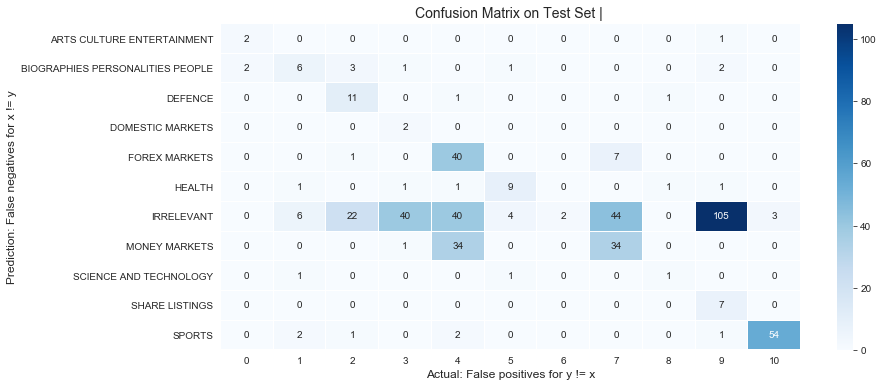

----------------------------------------------------------------------
Now, the train_df is full_train, the test_df is df_test_50
F1 score for  SVC  model is  0.3871426186915233
Accuracy score for  SVC  model is  0.352
Recall score for  SVC  model is  0.6564363363562449 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.39      0.47      0.42        15
           2       0.28      0.85      0.42        13
           3       0.04      1.00      0.08         2
           4       0.34      0.88      0.49        48
           5       0.67      0.57      0.62        14
           6       1.00      0.02      0.04       266
           7       0.39    

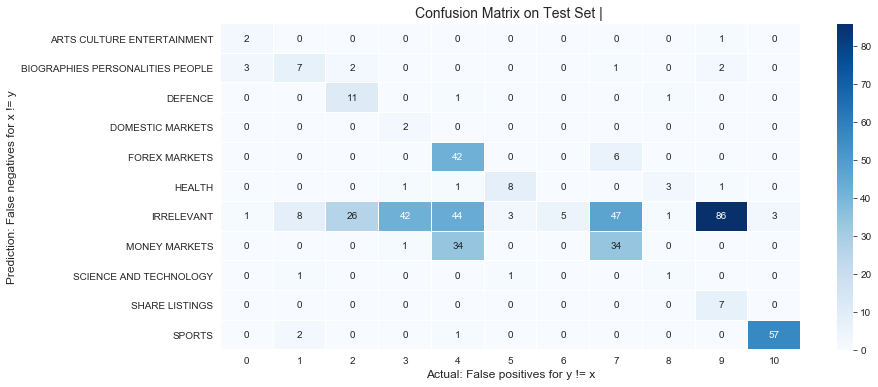

----------------------------------------------------------------------
Now, the train_df is full_train, the test_df is df_test_100
F1 score for  SVC  model is  0.41344980574479523
Accuracy score for  SVC  model is  0.378
Recall score for  SVC  model is  0.6950847112460385 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.42      0.53      0.47        15
           2       0.28      0.85      0.42        13
           3       0.05      1.00      0.09         2
           4       0.36      0.90      0.51        48
           5       0.58      0.50      0.54        14
           6       1.00      0.05      0.09       266
           7       0.41  

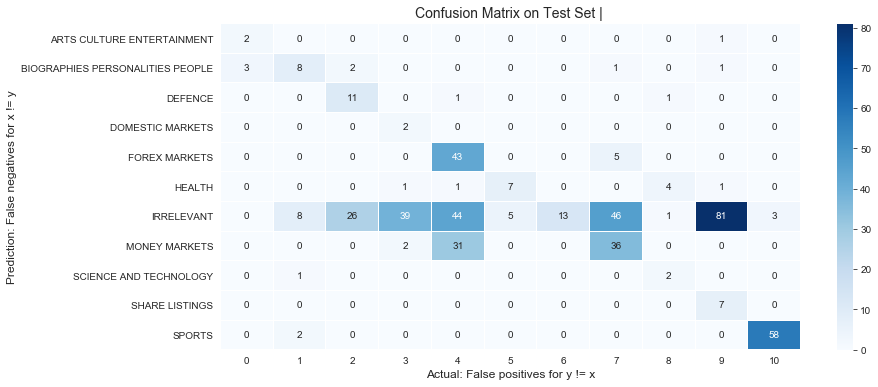

----------------------------------------------------------------------
Now, the train_df is full_train, the test_df is df_test_full
F1 score for  SVC  model is  0.42954992421968347
Accuracy score for  SVC  model is  0.412
Recall score for  SVC  model is  0.6956069959788496 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.45      0.60      0.51        15
           2       0.30      0.92      0.45        13
           3       0.05      1.00      0.10         2
           4       0.36      0.90      0.51        48
           5       0.56      0.64      0.60        14
           6       0.96      0.10      0.18       266
           7       0.40 

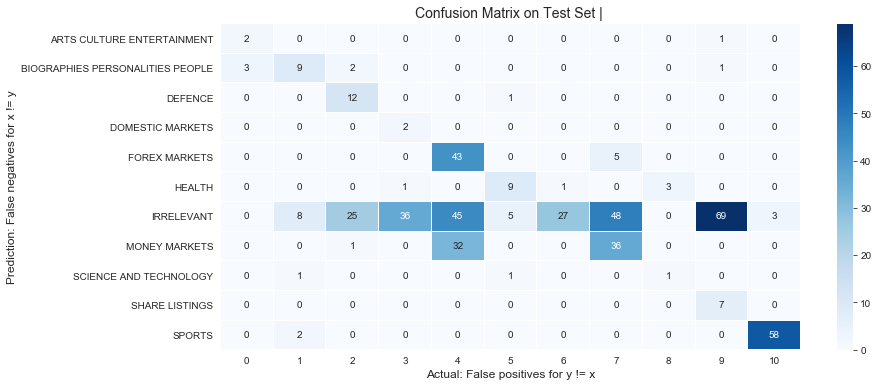

----------------------------------------------------------------------
Now, the train_df is full_train, the test_df is df_test_20
F1 score for  SVC  model is  0.40054367127122587
Accuracy score for  SVC  model is  0.408
Recall score for  SVC  model is  0.663122746818399 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.21      0.27      0.24        15
           2       0.30      0.92      0.45        13
           3       0.05      1.00      0.10         2
           4       0.36      0.88      0.51        48
           5       0.53      0.71      0.61        14
           6       0.90      0.14      0.25       266
           7       0.46    

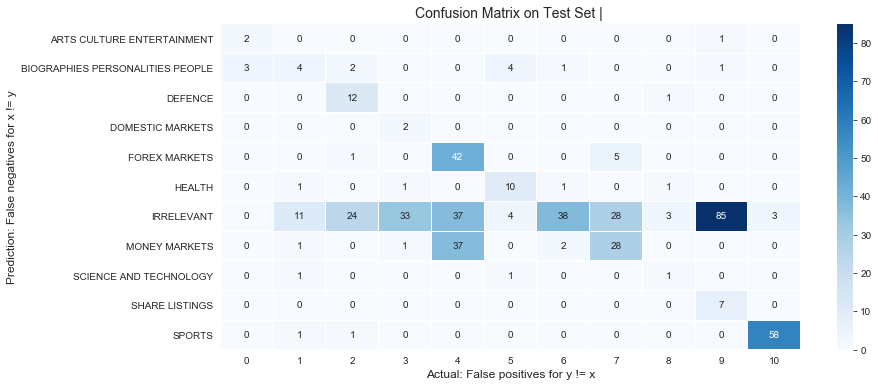

----------------------------------------------------------------------
Now, the train_df is full_train, the test_df is df_test_50
F1 score for  SVC  model is  0.46150517040884814
Accuracy score for  SVC  model is  0.478
Recall score for  SVC  model is  0.7381735160339279 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       0.33      0.53      0.41        15
           2       0.30      0.92      0.45        13
           3       0.06      1.00      0.11         2
           4       0.39      0.88      0.54        48
           5       0.65      0.79      0.71        14
           6       0.95      0.24      0.38       266
           7       0.47   

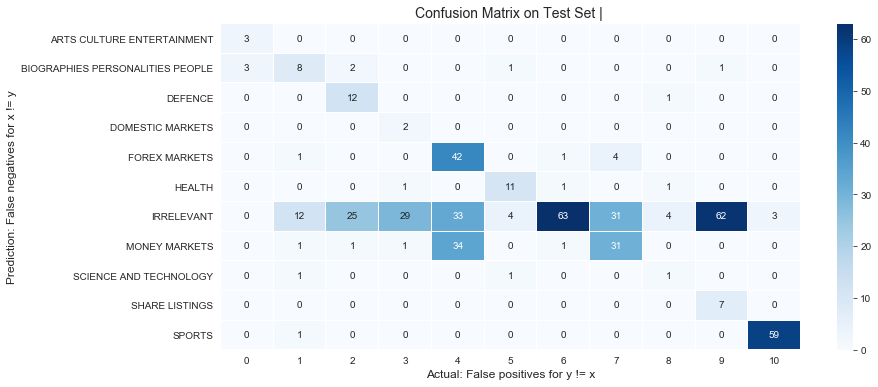

----------------------------------------------------------------------
Now, the train_df is full_train, the test_df is df_test_100
F1 score for  SVC  model is  0.5073279288859229
Accuracy score for  SVC  model is  0.548
Recall score for  SVC  model is  0.7645002023148475 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       0.43      0.67      0.53        15
           2       0.32      0.92      0.48        13
           3       0.07      1.00      0.13         2
           4       0.40      0.88      0.55        48
           5       0.69      0.79      0.73        14
           6       0.96      0.35      0.51       266
           7       0.48   

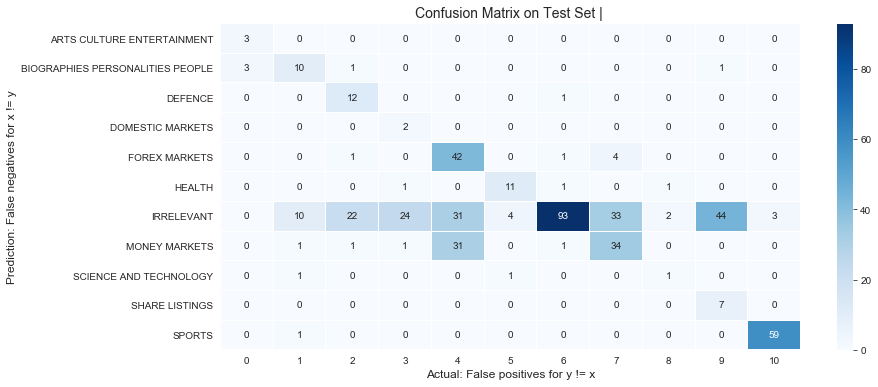

----------------------------------------------------------------------
Now, the train_df is full_train, the test_df is df_test_full
F1 score for  SVC  model is  0.5925725422792874
Accuracy score for  SVC  model is  0.746
Recall score for  SVC  model is  0.7194763474511757 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.57      0.53      0.55        15
           2       0.55      0.85      0.67        13
           3       0.14      1.00      0.25         2
           4       0.50      0.88      0.64        48
           5       0.75      0.86      0.80        14
           6       0.92      0.74      0.82       266
           7       0.62  

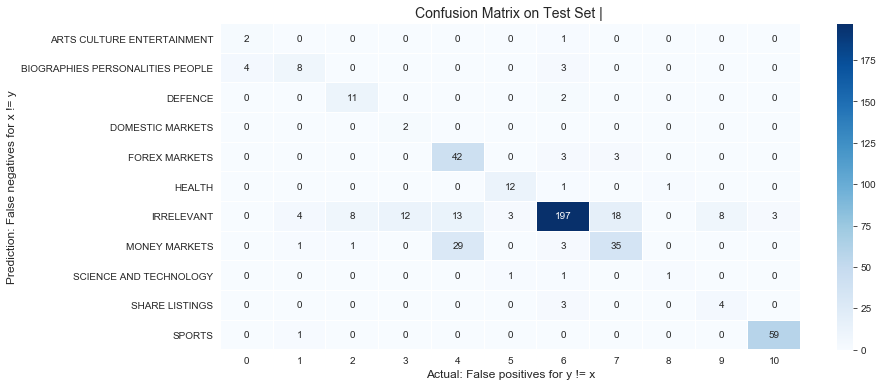

In [61]:
final_model_list = [final_model1,final_model2 ]
vect_list = [CountVectorizer().fit(train_x),TfidfVectorizer().fit(train_x)]
for i in  range(2):
    model = final_model_list[i]
    the_vect = vect_list[i]
    for test_df in df_test_all:
        if (test_df.isnull().values.any()):
            continue
        print('----------------------------------------------------------------------')
        print(f'Now, the train_df is full_train, the test_df is {test_df.name}')
        test_model(test_df, model,le,encode_mapping,the_vect)

In [3]:
my_model = retrieve_variable('svm_wc_tf')

In [12]:
#my_model
junk_train = df_train.rename(columns={ "article_words": "key_word"})
new_df = junk_train
new_df = new_df.dropna()
train_y = new_df.topic
train_x = new_df.key_word.apply(lambda x: x.replace('_', ''))
le = preprocessing.LabelEncoder()
le.fit(train_y)
encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
the_vect = TfidfVectorizer().fit(train_x)

----------------------------------------------------------------------
Now, the train_df is full_train, the test_df is df_test_20
F1 score for  SVC  model is  0.40054367127122587
Accuracy score for  SVC  model is  0.408
Recall score for  SVC  model is  0.663122746818399 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.21      0.27      0.24        15
           2       0.30      0.92      0.45        13
           3       0.05      1.00      0.10         2
           4       0.36      0.88      0.51        48
           5       0.53      0.71      0.61        14
           6       0.90      0.14      0.25       266
           7       0.46    

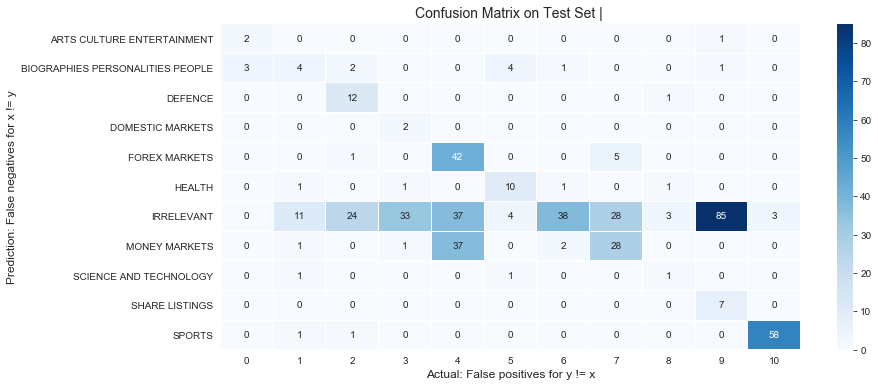

----------------------------------------------------------------------
Now, the train_df is full_train, the test_df is df_test_50
F1 score for  SVC  model is  0.46150517040884814
Accuracy score for  SVC  model is  0.478
Recall score for  SVC  model is  0.7381735160339279 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       0.33      0.53      0.41        15
           2       0.30      0.92      0.45        13
           3       0.06      1.00      0.11         2
           4       0.39      0.88      0.54        48
           5       0.65      0.79      0.71        14
           6       0.95      0.24      0.38       266
           7       0.47   

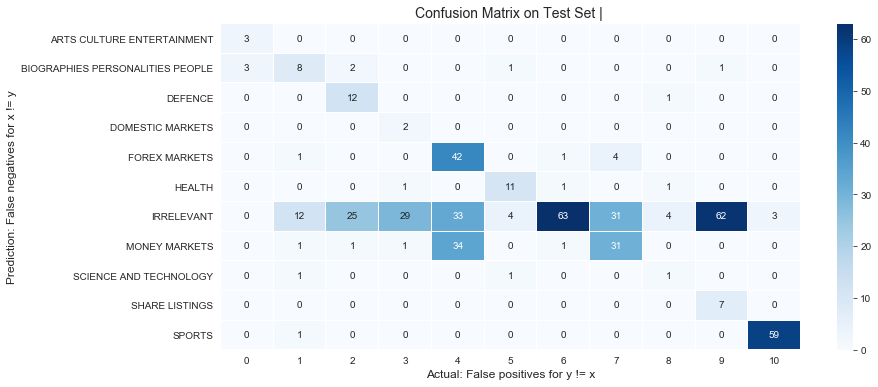

----------------------------------------------------------------------
Now, the train_df is full_train, the test_df is df_test_100
F1 score for  SVC  model is  0.5073279288859229
Accuracy score for  SVC  model is  0.548
Recall score for  SVC  model is  0.7645002023148475 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       0.43      0.67      0.53        15
           2       0.32      0.92      0.48        13
           3       0.07      1.00      0.13         2
           4       0.40      0.88      0.55        48
           5       0.69      0.79      0.73        14
           6       0.96      0.35      0.51       266
           7       0.48   

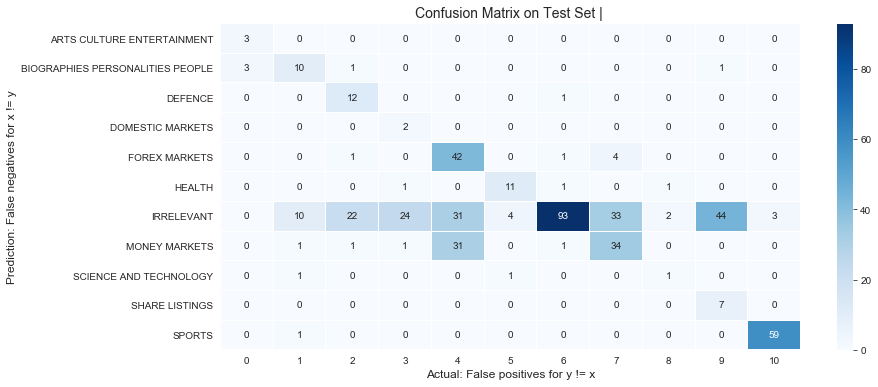

----------------------------------------------------------------------
Now, the train_df is full_train, the test_df is df_test_full
F1 score for  SVC  model is  0.5925725422792874
Accuracy score for  SVC  model is  0.746
Recall score for  SVC  model is  0.7194763474511757 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.57      0.53      0.55        15
           2       0.55      0.85      0.67        13
           3       0.14      1.00      0.25         2
           4       0.50      0.88      0.64        48
           5       0.75      0.86      0.80        14
           6       0.92      0.74      0.82       266
           7       0.62  

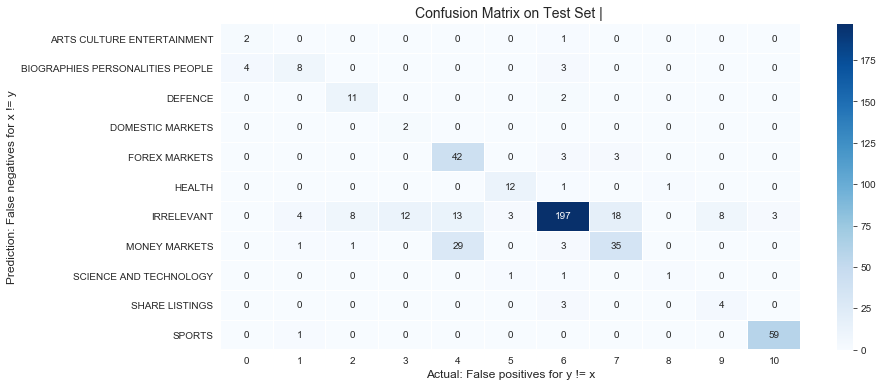

In [13]:
for test_df in df_test_all:
    if (test_df.isnull().values.any()):
        continue
    print('----------------------------------------------------------------------')
    print(f'Now, the train_df is full_train, the test_df is {test_df.name}')
    test_model(test_df, final_mode_prob,le,encode_mapping,the_vect)

In [15]:
my_model

SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [20]:
test_df.key_word[4]

'provid,provid,luxembourg,court,court,case,opinion,measur,rule,rule,ground,ground,law,apply,take,mortg,end,proceed,unit,unit,unit,unit,stat,stat,stat,stat,stat,stat,stat,attempt,eu,eu,eu,eu,justif,justif,includ,procedur,reply,enjoy,typ,singl,singl,singl,singl,singl,cross,hold,hold,progress,barry,barry,capit,capit,undertak,decid,invest,invest,invest,invest,invest,invest,bank,early,memb,memb,memb,memb,memb,slow,intern,year,fail,justic,determin,european,european,european,european,european,trust,trust,trust,mont,action,treat,treat,brok,impos,impos,stag,august,develop,servic,servic,servic,servic,servic,servic,servic,servic,servic,servic,back,move,need,foreign,launch,consid,consid,establ,establ,establ,good,germ,advant,public,public,remov,report,infring,infring,protect,compet,execut,part,effect,effect,insur,buy,tax,violat,lend,obstruc,nation,disproport,market,market,market,market,market,market,market,german,german,german,german,german,suppl,monday,interest,provis,vigor,mario,legal,legal,call,

In [17]:
results = final_mode_prob.predict_proba(the_vect.transform(test_df.key_word[2:4])[0])

In [18]:
results

array([[5.27153960e-05, 2.58389350e-05, 3.47823246e-06, 1.32653186e-05,
        4.42460856e-01, 8.02653050e-06, 3.48486798e-03, 5.53867309e-01,
        1.56648391e-06, 7.65603701e-05, 5.51549313e-06]])

In [21]:
max(results[0])/sum(results[0])

0.553867308839798

In [10]:
from collections import Counter
import pandas as pd

def word_list_generator(data_group, n=10):
    my_word_list= []
    for name, group in data_group :
        frequent_words = Counter(" ".join(group["article_words"]).split(",")).most_common(n)
        #most_frequent_word_list.update({name:frequent_words})
        common_words = [i[0] for i in frequent_words]
        my_word_list = my_word_list + common_words
    return(my_word_list)

def keep_key_words(x,word_list):
    key_list = [i for i in x.split(",") if i in  word_list]
    key_str = str(key_list).replace("'","").replace(" ","").replace("[","").replace("]","")
    return(key_str)

def df_keyword_generator(df_test, df_keywords):
    '''generate key words features in df_test based on keywords in df_keywords by topic '''
    topic_group = df_keywords.groupby('topic')
    words_in_df = df_test.article_words
    
    word_list10 = word_list_generator(topic_group, n=10)
    key_word_10 = words_in_df.apply(keep_key_words, args=(word_list10,))
    df_test['key_word_10'] = key_word_10
    
    word_list20 = word_list_generator(topic_group, n=20)
    key_word_20 = words_in_df.apply(keep_key_words, args=(word_list20,))
    df_test['key_word_20'] = key_word_20
    
    word_list50 = word_list_generator(topic_group, n=50)
    key_word_50 = words_in_df.apply(keep_key_words, args=(word_list50,))
    df_test['key_word_50'] = key_word_50
    
    word_list100 = word_list_generator(topic_group, n=100)
    key_word_100 = words_in_df.apply(keep_key_words, args=(word_list100,))
    df_test['key_word_100'] = key_word_100
    
    return(df_test)

df_train = pd.read_csv("training.csv")
df_test = pd.read_csv("test.csv")
my_test = df_keyword_generator(df_test,df_train)
my_train = df_keyword_generator(df_train,df_train)